# Imports

In [1]:
import os
os.chdir('/home/jupyter/ee_tree_counting/Models/SSD')

In [9]:
from config import (
    DEVICE, 
    NUM_CLASSES, 
    NUM_EPOCHS, 
    OUT_DIR,
    VISUALIZE_TRANSFORMED_IMAGES, 
    NUM_WORKERS,
    RESIZE_TO,
    VALID_DIR,
    TRAIN_DIR,
    WEIGHTS_PATH
)
from model import create_model
from custom_utils import (
    Averager, 
    SaveBestModel, 
    save_model, 
    save_loss_plot,
    save_mAP
)
from tqdm.auto import tqdm
from datasets import (
    create_train_dataset, 
    create_valid_dataset, 
    create_train_loader, 
    create_valid_loader
)
from torchmetrics.detection.mean_ap import MeanAveragePrecision
from torch.optim.lr_scheduler import StepLR

import torch
import matplotlib.pyplot as plt
import time
import os
import csv

plt.style.use('ggplot')

seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

In [3]:
# Initialize the model and move to the computation device.
model = create_model(num_classes=NUM_CLASSES, size=RESIZE_TO, weights_path=WEIGHTS_PATH)
print(model)

SSD(
  (backbone): SSDFeatureExtractorVGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=

In [6]:
# Function for running training iterations.
def train(train_data_loader, model):
    print('Training')
    model.train()
    
     # initialize tqdm progress bar
    prog_bar = tqdm(train_data_loader, total=len(train_data_loader))
    
    for i, data in enumerate(prog_bar):
        optimizer.zero_grad()
        images, targets = data
        
        images = list(image.to(DEVICE) for image in images)
        targets = [{k: v.to(DEVICE) for k, v in t.items()} for t in targets]
        loss_dict = model(images, targets)

        losses = sum(loss for loss in loss_dict.values())
        loss_value = losses.item()

        train_loss_hist.send(loss_value)

        losses.backward()
        optimizer.step()
    
        # update the loss value beside the progress bar for each iteration
        prog_bar.set_description(desc=f"Loss: {loss_value:.4f}")
    return loss_value

In [7]:
def validate(valid_data_loader, model):
    print('Validating')
    model.eval()
    
    # Initialize tqdm progress bar.
    prog_bar = tqdm(valid_data_loader, total=len(valid_data_loader))
    target = []
    preds = []
    for i, data in enumerate(prog_bar):
        images, targets = data
        
        images = list(image.to(DEVICE) for image in images)
        targets = [{k: v.to(DEVICE) for k, v in t.items()} for t in targets]
        
        with torch.no_grad():
            outputs = model(images, targets)

        # For mAP calculation using Torchmetrics.
        #####################################
        for i in range(len(images)):
            true_dict = dict()
            preds_dict = dict()
            true_dict['boxes'] = targets[i]['boxes'].detach().cpu()
            true_dict['labels'] = targets[i]['labels'].detach().cpu()
            preds_dict['boxes'] = outputs[i]['boxes'].detach().cpu()
            preds_dict['scores'] = outputs[i]['scores'].detach().cpu()
            preds_dict['labels'] = outputs[i]['labels'].detach().cpu()
            preds.append(preds_dict)
            target.append(true_dict)
        #####################################

    metric = MeanAveragePrecision()
    metric.update(preds, target)
    metric_summary = metric.compute()
    return metric_summary

/opt/conda/lib/python3.10/site-packages/albumentations/core/composition.py:156: UserWarning: Got processor for bboxes, but no transform to process it.
  self._set_keys()


Number of training samples: 379
Number of validation samples: 59

23,745,908 total parameters.
23,745,908 training parameters.
Adjusting learning rate of group 0 to 1.0000e-04.

EPOCH 1 of 100
Training


  0%|          | 0/94 [00:00<?, ?it/s]

Validating


  0%|          | 0/14 [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: Encountered more than 100 detections in a single image. This means that certain detections with the lowest scores will be ignored, that may have an undesirable impact on performance. Please consider adjusting the `max_detection_threshold` to suit your use case. To disable this warning, set attribute class `warn_on_many_detections=False`, after initializing the metric.
  warnings.warn(*args, **kwargs)  # noqa: B028


Epoch #1 train loss: 4.924
Epoch #1 mAP@0.5: 0.85%
Epoch #1 mAP@0.5:0.95: 0.20%
Took 0.957 minutes for epoch 0

BEST VALIDATION mAP: 0.001996926963329315

SAVING BEST MODEL FOR EPOCH: 1

SAVING PLOTS COMPLETE...
Adjusting learning rate of group 0 to 1.0000e-04.

EPOCH 2 of 100
Training


  0%|          | 0/94 [00:00<?, ?it/s]

Validating


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch #2 train loss: 4.051
Epoch #2 mAP@0.5: 8.19%
Epoch #2 mAP@0.5:0.95: 2.37%
Took 0.848 minutes for epoch 1

BEST VALIDATION mAP: 0.023650608956813812

SAVING BEST MODEL FOR EPOCH: 2

SAVING PLOTS COMPLETE...
Adjusting learning rate of group 0 to 1.0000e-04.

EPOCH 3 of 100
Training


  0%|          | 0/94 [00:00<?, ?it/s]

Validating


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch #3 train loss: 3.824
Epoch #3 mAP@0.5: 24.88%
Epoch #3 mAP@0.5:0.95: 7.81%
Took 0.831 minutes for epoch 2

BEST VALIDATION mAP: 0.0781194269657135

SAVING BEST MODEL FOR EPOCH: 3

SAVING PLOTS COMPLETE...
Adjusting learning rate of group 0 to 1.0000e-04.

EPOCH 4 of 100
Training


  0%|          | 0/94 [00:00<?, ?it/s]

Validating


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch #4 train loss: 3.699
Epoch #4 mAP@0.5: 44.80%
Epoch #4 mAP@0.5:0.95: 15.12%
Took 0.830 minutes for epoch 3

BEST VALIDATION mAP: 0.15120746195316315

SAVING BEST MODEL FOR EPOCH: 4

SAVING PLOTS COMPLETE...
Adjusting learning rate of group 0 to 1.0000e-04.

EPOCH 5 of 100
Training


  0%|          | 0/94 [00:00<?, ?it/s]

Validating


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch #5 train loss: 3.605
Epoch #5 mAP@0.5: 53.47%
Epoch #5 mAP@0.5:0.95: 18.77%
Took 0.832 minutes for epoch 4

BEST VALIDATION mAP: 0.18773965537548065

SAVING BEST MODEL FOR EPOCH: 5

SAVING PLOTS COMPLETE...
Adjusting learning rate of group 0 to 1.0000e-04.

EPOCH 6 of 100
Training


  0%|          | 0/94 [00:00<?, ?it/s]

Validating


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch #6 train loss: 3.525
Epoch #6 mAP@0.5: 58.86%
Epoch #6 mAP@0.5:0.95: 20.51%
Took 0.843 minutes for epoch 5

BEST VALIDATION mAP: 0.2051302045583725

SAVING BEST MODEL FOR EPOCH: 6

SAVING PLOTS COMPLETE...
Adjusting learning rate of group 0 to 1.0000e-04.

EPOCH 7 of 100
Training


  0%|          | 0/94 [00:00<?, ?it/s]

Validating


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch #7 train loss: 3.469
Epoch #7 mAP@0.5: 61.33%
Epoch #7 mAP@0.5:0.95: 22.18%
Took 0.837 minutes for epoch 6

BEST VALIDATION mAP: 0.22180025279521942

SAVING BEST MODEL FOR EPOCH: 7

SAVING PLOTS COMPLETE...
Adjusting learning rate of group 0 to 1.0000e-04.

EPOCH 8 of 100
Training


  0%|          | 0/94 [00:00<?, ?it/s]

Validating


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch #8 train loss: 3.410
Epoch #8 mAP@0.5: 63.62%
Epoch #8 mAP@0.5:0.95: 22.64%
Took 0.828 minutes for epoch 7

BEST VALIDATION mAP: 0.2263692021369934

SAVING BEST MODEL FOR EPOCH: 8

SAVING PLOTS COMPLETE...
Adjusting learning rate of group 0 to 1.0000e-04.

EPOCH 9 of 100
Training


  0%|          | 0/94 [00:00<?, ?it/s]

Validating


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch #9 train loss: 3.360
Epoch #9 mAP@0.5: 62.99%
Epoch #9 mAP@0.5:0.95: 23.42%
Took 0.825 minutes for epoch 8

BEST VALIDATION mAP: 0.23416484892368317

SAVING BEST MODEL FOR EPOCH: 9

SAVING PLOTS COMPLETE...
Adjusting learning rate of group 0 to 1.0000e-04.

EPOCH 10 of 100
Training


  0%|          | 0/94 [00:00<?, ?it/s]

Validating


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch #10 train loss: 3.296
Epoch #10 mAP@0.5: 65.29%
Epoch #10 mAP@0.5:0.95: 24.23%
Took 0.828 minutes for epoch 9

BEST VALIDATION mAP: 0.24229472875595093

SAVING BEST MODEL FOR EPOCH: 10

SAVING PLOTS COMPLETE...
Adjusting learning rate of group 0 to 1.0000e-04.

EPOCH 11 of 100
Training


  0%|          | 0/94 [00:00<?, ?it/s]

Validating


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch #11 train loss: 3.266
Epoch #11 mAP@0.5: 66.40%
Epoch #11 mAP@0.5:0.95: 24.69%
Took 0.823 minutes for epoch 10

BEST VALIDATION mAP: 0.2468644082546234

SAVING BEST MODEL FOR EPOCH: 11

SAVING PLOTS COMPLETE...
Adjusting learning rate of group 0 to 1.0000e-04.

EPOCH 12 of 100
Training


  0%|          | 0/94 [00:00<?, ?it/s]

Validating


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch #12 train loss: 3.215
Epoch #12 mAP@0.5: 65.43%
Epoch #12 mAP@0.5:0.95: 24.92%
Took 0.832 minutes for epoch 11

BEST VALIDATION mAP: 0.24924519658088684

SAVING BEST MODEL FOR EPOCH: 12

SAVING PLOTS COMPLETE...
Adjusting learning rate of group 0 to 1.0000e-04.

EPOCH 13 of 100
Training


  0%|          | 0/94 [00:00<?, ?it/s]

Validating


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch #13 train loss: 3.190
Epoch #13 mAP@0.5: 67.97%
Epoch #13 mAP@0.5:0.95: 25.47%
Took 0.830 minutes for epoch 12

BEST VALIDATION mAP: 0.25473034381866455

SAVING BEST MODEL FOR EPOCH: 13

SAVING PLOTS COMPLETE...
Adjusting learning rate of group 0 to 1.0000e-04.

EPOCH 14 of 100
Training


  0%|          | 0/94 [00:00<?, ?it/s]

Validating


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch #14 train loss: 3.144
Epoch #14 mAP@0.5: 67.85%
Epoch #14 mAP@0.5:0.95: 25.76%
Took 0.824 minutes for epoch 13

BEST VALIDATION mAP: 0.2575565576553345

SAVING BEST MODEL FOR EPOCH: 14

SAVING PLOTS COMPLETE...
Adjusting learning rate of group 0 to 1.0000e-04.

EPOCH 15 of 100
Training


  0%|          | 0/94 [00:00<?, ?it/s]

Validating


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch #15 train loss: 3.099
Epoch #15 mAP@0.5: 67.96%
Epoch #15 mAP@0.5:0.95: 26.15%
Took 0.819 minutes for epoch 14

BEST VALIDATION mAP: 0.26152104139328003

SAVING BEST MODEL FOR EPOCH: 15

SAVING PLOTS COMPLETE...
Adjusting learning rate of group 0 to 1.0000e-05.

EPOCH 16 of 100
Training


  0%|          | 0/94 [00:00<?, ?it/s]

Validating


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch #16 train loss: 3.072
Epoch #16 mAP@0.5: 68.47%
Epoch #16 mAP@0.5:0.95: 26.24%
Took 0.834 minutes for epoch 15

BEST VALIDATION mAP: 0.2624269425868988

SAVING BEST MODEL FOR EPOCH: 16

SAVING PLOTS COMPLETE...
Adjusting learning rate of group 0 to 1.0000e-05.

EPOCH 17 of 100
Training


  0%|          | 0/94 [00:00<?, ?it/s]

Validating


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch #17 train loss: 3.061
Epoch #17 mAP@0.5: 69.27%
Epoch #17 mAP@0.5:0.95: 26.36%
Took 0.823 minutes for epoch 16

BEST VALIDATION mAP: 0.2635610103607178

SAVING BEST MODEL FOR EPOCH: 17

SAVING PLOTS COMPLETE...
Adjusting learning rate of group 0 to 1.0000e-05.

EPOCH 18 of 100
Training


  0%|          | 0/94 [00:00<?, ?it/s]

Validating


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch #18 train loss: 3.065
Epoch #18 mAP@0.5: 69.45%
Epoch #18 mAP@0.5:0.95: 26.27%
Took 0.834 minutes for epoch 17
SAVING PLOTS COMPLETE...
Adjusting learning rate of group 0 to 1.0000e-05.

EPOCH 19 of 100
Training


  0%|          | 0/94 [00:00<?, ?it/s]

Validating


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch #19 train loss: 3.054
Epoch #19 mAP@0.5: 68.51%
Epoch #19 mAP@0.5:0.95: 26.49%
Took 0.841 minutes for epoch 18

BEST VALIDATION mAP: 0.2649141848087311

SAVING BEST MODEL FOR EPOCH: 19

SAVING PLOTS COMPLETE...
Adjusting learning rate of group 0 to 1.0000e-05.

EPOCH 20 of 100
Training


  0%|          | 0/94 [00:00<?, ?it/s]

Validating


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch #20 train loss: 3.060
Epoch #20 mAP@0.5: 68.68%
Epoch #20 mAP@0.5:0.95: 26.46%
Took 0.829 minutes for epoch 19
SAVING PLOTS COMPLETE...
Adjusting learning rate of group 0 to 1.0000e-05.

EPOCH 21 of 100
Training


  0%|          | 0/94 [00:00<?, ?it/s]

Validating


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch #21 train loss: 3.051
Epoch #21 mAP@0.5: 69.38%
Epoch #21 mAP@0.5:0.95: 26.56%
Took 0.830 minutes for epoch 20

BEST VALIDATION mAP: 0.2655677795410156

SAVING BEST MODEL FOR EPOCH: 21

SAVING PLOTS COMPLETE...
Adjusting learning rate of group 0 to 1.0000e-05.

EPOCH 22 of 100
Training


  0%|          | 0/94 [00:00<?, ?it/s]

Validating


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch #22 train loss: 3.041
Epoch #22 mAP@0.5: 69.56%
Epoch #22 mAP@0.5:0.95: 26.39%
Took 0.819 minutes for epoch 21
SAVING PLOTS COMPLETE...
Adjusting learning rate of group 0 to 1.0000e-05.

EPOCH 23 of 100
Training


  0%|          | 0/94 [00:00<?, ?it/s]

Validating


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch #23 train loss: 3.052
Epoch #23 mAP@0.5: 69.47%
Epoch #23 mAP@0.5:0.95: 26.50%
Took 0.819 minutes for epoch 22
SAVING PLOTS COMPLETE...
Adjusting learning rate of group 0 to 1.0000e-05.

EPOCH 24 of 100
Training


  0%|          | 0/94 [00:00<?, ?it/s]

Validating


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch #24 train loss: 3.040
Epoch #24 mAP@0.5: 69.29%
Epoch #24 mAP@0.5:0.95: 26.65%
Took 0.822 minutes for epoch 23

BEST VALIDATION mAP: 0.2664841413497925

SAVING BEST MODEL FOR EPOCH: 24

SAVING PLOTS COMPLETE...
Adjusting learning rate of group 0 to 1.0000e-05.

EPOCH 25 of 100
Training


  0%|          | 0/94 [00:00<?, ?it/s]

Validating


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch #25 train loss: 3.032
Epoch #25 mAP@0.5: 69.45%
Epoch #25 mAP@0.5:0.95: 26.68%
Took 0.831 minutes for epoch 24

BEST VALIDATION mAP: 0.26682743430137634

SAVING BEST MODEL FOR EPOCH: 25

SAVING PLOTS COMPLETE...
Adjusting learning rate of group 0 to 1.0000e-05.

EPOCH 26 of 100
Training


  0%|          | 0/94 [00:00<?, ?it/s]

Validating


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch #26 train loss: 3.030
Epoch #26 mAP@0.5: 69.55%
Epoch #26 mAP@0.5:0.95: 26.49%
Took 0.833 minutes for epoch 25
SAVING PLOTS COMPLETE...
Adjusting learning rate of group 0 to 1.0000e-05.

EPOCH 27 of 100
Training


  0%|          | 0/94 [00:00<?, ?it/s]

Validating


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch #27 train loss: 3.037
Epoch #27 mAP@0.5: 69.69%
Epoch #27 mAP@0.5:0.95: 26.49%
Took 0.841 minutes for epoch 26
SAVING PLOTS COMPLETE...
Adjusting learning rate of group 0 to 1.0000e-05.

EPOCH 28 of 100
Training


  0%|          | 0/94 [00:00<?, ?it/s]

Validating


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch #28 train loss: 3.024
Epoch #28 mAP@0.5: 69.52%
Epoch #28 mAP@0.5:0.95: 26.75%
Took 0.833 minutes for epoch 27

BEST VALIDATION mAP: 0.26745423674583435

SAVING BEST MODEL FOR EPOCH: 28

SAVING PLOTS COMPLETE...
Adjusting learning rate of group 0 to 1.0000e-05.

EPOCH 29 of 100
Training


  0%|          | 0/94 [00:00<?, ?it/s]

Validating


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch #29 train loss: 3.017
Epoch #29 mAP@0.5: 69.62%
Epoch #29 mAP@0.5:0.95: 26.81%
Took 0.831 minutes for epoch 28

BEST VALIDATION mAP: 0.26814189553260803

SAVING BEST MODEL FOR EPOCH: 29

SAVING PLOTS COMPLETE...
Adjusting learning rate of group 0 to 1.0000e-05.

EPOCH 30 of 100
Training


  0%|          | 0/94 [00:00<?, ?it/s]

Validating


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch #30 train loss: 3.022
Epoch #30 mAP@0.5: 69.59%
Epoch #30 mAP@0.5:0.95: 26.78%
Took 0.828 minutes for epoch 29
SAVING PLOTS COMPLETE...
Adjusting learning rate of group 0 to 1.0000e-06.

EPOCH 31 of 100
Training


  0%|          | 0/94 [00:00<?, ?it/s]

Validating


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch #31 train loss: 3.015
Epoch #31 mAP@0.5: 69.59%
Epoch #31 mAP@0.5:0.95: 26.82%
Took 0.819 minutes for epoch 30

BEST VALIDATION mAP: 0.2681690454483032

SAVING BEST MODEL FOR EPOCH: 31

SAVING PLOTS COMPLETE...
Adjusting learning rate of group 0 to 1.0000e-06.

EPOCH 32 of 100
Training


  0%|          | 0/94 [00:00<?, ?it/s]

Validating


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch #32 train loss: 3.021
Epoch #32 mAP@0.5: 69.61%
Epoch #32 mAP@0.5:0.95: 26.77%
Took 0.842 minutes for epoch 31
SAVING PLOTS COMPLETE...
Adjusting learning rate of group 0 to 1.0000e-06.

EPOCH 33 of 100
Training


  0%|          | 0/94 [00:00<?, ?it/s]

Validating


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch #33 train loss: 3.010
Epoch #33 mAP@0.5: 69.67%
Epoch #33 mAP@0.5:0.95: 26.78%
Took 0.834 minutes for epoch 32
SAVING PLOTS COMPLETE...
Adjusting learning rate of group 0 to 1.0000e-06.

EPOCH 34 of 100
Training


  0%|          | 0/94 [00:00<?, ?it/s]

Validating


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch #34 train loss: 3.016
Epoch #34 mAP@0.5: 69.65%
Epoch #34 mAP@0.5:0.95: 26.85%
Took 0.829 minutes for epoch 33

BEST VALIDATION mAP: 0.26852285861968994

SAVING BEST MODEL FOR EPOCH: 34

SAVING PLOTS COMPLETE...
Adjusting learning rate of group 0 to 1.0000e-06.

EPOCH 35 of 100
Training


  0%|          | 0/94 [00:00<?, ?it/s]

Validating


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch #35 train loss: 3.021
Epoch #35 mAP@0.5: 69.69%
Epoch #35 mAP@0.5:0.95: 26.84%
Took 0.816 minutes for epoch 34
SAVING PLOTS COMPLETE...
Adjusting learning rate of group 0 to 1.0000e-06.

EPOCH 36 of 100
Training


  0%|          | 0/94 [00:00<?, ?it/s]

Validating


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch #36 train loss: 3.017
Epoch #36 mAP@0.5: 69.65%
Epoch #36 mAP@0.5:0.95: 26.87%
Took 0.831 minutes for epoch 35

BEST VALIDATION mAP: 0.26866137981414795

SAVING BEST MODEL FOR EPOCH: 36

SAVING PLOTS COMPLETE...
Adjusting learning rate of group 0 to 1.0000e-06.

EPOCH 37 of 100
Training


  0%|          | 0/94 [00:00<?, ?it/s]

Validating


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch #37 train loss: 3.006
Epoch #37 mAP@0.5: 69.75%
Epoch #37 mAP@0.5:0.95: 26.86%
Took 0.817 minutes for epoch 36
SAVING PLOTS COMPLETE...
Adjusting learning rate of group 0 to 1.0000e-06.

EPOCH 38 of 100
Training


  0%|          | 0/94 [00:00<?, ?it/s]

Validating


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch #38 train loss: 3.020
Epoch #38 mAP@0.5: 69.72%
Epoch #38 mAP@0.5:0.95: 26.87%
Took 0.828 minutes for epoch 37

BEST VALIDATION mAP: 0.26871395111083984

SAVING BEST MODEL FOR EPOCH: 38

SAVING PLOTS COMPLETE...
Adjusting learning rate of group 0 to 1.0000e-06.

EPOCH 39 of 100
Training


  0%|          | 0/94 [00:00<?, ?it/s]

Validating


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch #39 train loss: 3.008
Epoch #39 mAP@0.5: 69.75%
Epoch #39 mAP@0.5:0.95: 26.88%
Took 0.823 minutes for epoch 38

BEST VALIDATION mAP: 0.2688009738922119

SAVING BEST MODEL FOR EPOCH: 39

SAVING PLOTS COMPLETE...
Adjusting learning rate of group 0 to 1.0000e-06.

EPOCH 40 of 100
Training


  0%|          | 0/94 [00:00<?, ?it/s]

Validating


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch #40 train loss: 3.016
Epoch #40 mAP@0.5: 69.73%
Epoch #40 mAP@0.5:0.95: 26.84%
Took 0.815 minutes for epoch 39
SAVING PLOTS COMPLETE...
Adjusting learning rate of group 0 to 1.0000e-06.

EPOCH 41 of 100
Training


  0%|          | 0/94 [00:00<?, ?it/s]

Validating


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch #41 train loss: 3.008
Epoch #41 mAP@0.5: 69.72%
Epoch #41 mAP@0.5:0.95: 26.74%
Took 0.811 minutes for epoch 40
SAVING PLOTS COMPLETE...
Adjusting learning rate of group 0 to 1.0000e-06.

EPOCH 42 of 100
Training


  0%|          | 0/94 [00:00<?, ?it/s]

Validating


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch #42 train loss: 3.000
Epoch #42 mAP@0.5: 69.70%
Epoch #42 mAP@0.5:0.95: 26.85%
Took 0.825 minutes for epoch 41
SAVING PLOTS COMPLETE...
Adjusting learning rate of group 0 to 1.0000e-06.

EPOCH 43 of 100
Training


  0%|          | 0/94 [00:00<?, ?it/s]

Validating


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch #43 train loss: 3.010
Epoch #43 mAP@0.5: 69.75%
Epoch #43 mAP@0.5:0.95: 26.86%
Took 0.819 minutes for epoch 42
SAVING PLOTS COMPLETE...
Adjusting learning rate of group 0 to 1.0000e-06.

EPOCH 44 of 100
Training


  0%|          | 0/94 [00:00<?, ?it/s]

Validating


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch #44 train loss: 3.014
Epoch #44 mAP@0.5: 69.78%
Epoch #44 mAP@0.5:0.95: 26.89%
Took 0.820 minutes for epoch 43

BEST VALIDATION mAP: 0.26887083053588867

SAVING BEST MODEL FOR EPOCH: 44

SAVING PLOTS COMPLETE...
Adjusting learning rate of group 0 to 1.0000e-06.

EPOCH 45 of 100
Training


  0%|          | 0/94 [00:00<?, ?it/s]

Validating


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch #45 train loss: 3.003
Epoch #45 mAP@0.5: 69.72%
Epoch #45 mAP@0.5:0.95: 26.85%
Took 0.821 minutes for epoch 44
SAVING PLOTS COMPLETE...
Adjusting learning rate of group 0 to 1.0000e-07.

EPOCH 46 of 100
Training


  0%|          | 0/94 [00:00<?, ?it/s]

Validating


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch #46 train loss: 3.007
Epoch #46 mAP@0.5: 69.72%
Epoch #46 mAP@0.5:0.95: 26.86%
Took 0.817 minutes for epoch 45
SAVING PLOTS COMPLETE...
Adjusting learning rate of group 0 to 1.0000e-07.

EPOCH 47 of 100
Training


  0%|          | 0/94 [00:00<?, ?it/s]

Validating


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch #47 train loss: 3.013
Epoch #47 mAP@0.5: 69.70%
Epoch #47 mAP@0.5:0.95: 26.86%
Took 0.813 minutes for epoch 46
SAVING PLOTS COMPLETE...
Adjusting learning rate of group 0 to 1.0000e-07.

EPOCH 48 of 100
Training


  0%|          | 0/94 [00:00<?, ?it/s]

Validating


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch #48 train loss: 3.007
Epoch #48 mAP@0.5: 69.70%
Epoch #48 mAP@0.5:0.95: 26.86%
Took 0.825 minutes for epoch 47
SAVING PLOTS COMPLETE...
Adjusting learning rate of group 0 to 1.0000e-07.

EPOCH 49 of 100
Training


  0%|          | 0/94 [00:00<?, ?it/s]

Validating


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch #49 train loss: 3.015
Epoch #49 mAP@0.5: 69.75%
Epoch #49 mAP@0.5:0.95: 26.86%
Took 0.821 minutes for epoch 48
SAVING PLOTS COMPLETE...
Adjusting learning rate of group 0 to 1.0000e-07.

EPOCH 50 of 100
Training


  0%|          | 0/94 [00:00<?, ?it/s]

Validating


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch #50 train loss: 3.012
Epoch #50 mAP@0.5: 69.76%
Epoch #50 mAP@0.5:0.95: 26.87%
Took 0.817 minutes for epoch 49
SAVING PLOTS COMPLETE...
Adjusting learning rate of group 0 to 1.0000e-07.

EPOCH 51 of 100
Training


  0%|          | 0/94 [00:00<?, ?it/s]

Validating


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch #51 train loss: 3.008
Epoch #51 mAP@0.5: 69.76%
Epoch #51 mAP@0.5:0.95: 26.87%
Took 0.818 minutes for epoch 50
SAVING PLOTS COMPLETE...
Adjusting learning rate of group 0 to 1.0000e-07.

EPOCH 52 of 100
Training


  0%|          | 0/94 [00:00<?, ?it/s]

Validating


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch #52 train loss: 3.002
Epoch #52 mAP@0.5: 69.76%
Epoch #52 mAP@0.5:0.95: 26.87%
Took 0.816 minutes for epoch 51
SAVING PLOTS COMPLETE...
Adjusting learning rate of group 0 to 1.0000e-07.

EPOCH 53 of 100
Training


  0%|          | 0/94 [00:00<?, ?it/s]

Validating


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch #53 train loss: 3.009
Epoch #53 mAP@0.5: 69.76%
Epoch #53 mAP@0.5:0.95: 26.87%
Took 0.816 minutes for epoch 52
SAVING PLOTS COMPLETE...
Adjusting learning rate of group 0 to 1.0000e-07.

EPOCH 54 of 100
Training


  0%|          | 0/94 [00:00<?, ?it/s]

Validating


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch #54 train loss: 2.997
Epoch #54 mAP@0.5: 69.76%
Epoch #54 mAP@0.5:0.95: 26.87%
Took 0.814 minutes for epoch 53
SAVING PLOTS COMPLETE...
Adjusting learning rate of group 0 to 1.0000e-07.

EPOCH 55 of 100
Training


  0%|          | 0/94 [00:00<?, ?it/s]

Validating


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch #55 train loss: 3.009
Epoch #55 mAP@0.5: 69.76%
Epoch #55 mAP@0.5:0.95: 26.87%
Took 0.815 minutes for epoch 54
SAVING PLOTS COMPLETE...
Adjusting learning rate of group 0 to 1.0000e-07.

EPOCH 56 of 100
Training


  0%|          | 0/94 [00:00<?, ?it/s]

Validating


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch #56 train loss: 3.013
Epoch #56 mAP@0.5: 69.76%
Epoch #56 mAP@0.5:0.95: 26.87%
Took 0.818 minutes for epoch 55
SAVING PLOTS COMPLETE...
Adjusting learning rate of group 0 to 1.0000e-07.

EPOCH 57 of 100
Training


  0%|          | 0/94 [00:00<?, ?it/s]

Validating


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch #57 train loss: 3.005
Epoch #57 mAP@0.5: 69.76%
Epoch #57 mAP@0.5:0.95: 26.87%
Took 0.818 minutes for epoch 56
SAVING PLOTS COMPLETE...
Adjusting learning rate of group 0 to 1.0000e-07.

EPOCH 58 of 100
Training


  0%|          | 0/94 [00:00<?, ?it/s]

Validating


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch #58 train loss: 3.009
Epoch #58 mAP@0.5: 69.76%
Epoch #58 mAP@0.5:0.95: 26.87%
Took 0.817 minutes for epoch 57
SAVING PLOTS COMPLETE...
Adjusting learning rate of group 0 to 1.0000e-07.

EPOCH 59 of 100
Training


  0%|          | 0/94 [00:00<?, ?it/s]

Validating


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch #59 train loss: 3.008
Epoch #59 mAP@0.5: 69.76%
Epoch #59 mAP@0.5:0.95: 26.87%
Took 0.825 minutes for epoch 58
SAVING PLOTS COMPLETE...
Adjusting learning rate of group 0 to 1.0000e-07.

EPOCH 60 of 100
Training


  0%|          | 0/94 [00:00<?, ?it/s]

Validating


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch #60 train loss: 3.007
Epoch #60 mAP@0.5: 69.79%
Epoch #60 mAP@0.5:0.95: 26.88%
Took 0.824 minutes for epoch 59
SAVING PLOTS COMPLETE...
Adjusting learning rate of group 0 to 1.0000e-08.

EPOCH 61 of 100
Training


  0%|          | 0/94 [00:00<?, ?it/s]

Validating


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch #61 train loss: 3.013
Epoch #61 mAP@0.5: 69.79%
Epoch #61 mAP@0.5:0.95: 26.87%
Took 0.816 minutes for epoch 60
SAVING PLOTS COMPLETE...
Adjusting learning rate of group 0 to 1.0000e-08.

EPOCH 62 of 100
Training


  0%|          | 0/94 [00:00<?, ?it/s]

Validating


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch #62 train loss: 3.011
Epoch #62 mAP@0.5: 69.79%
Epoch #62 mAP@0.5:0.95: 26.87%
Took 0.815 minutes for epoch 61
SAVING PLOTS COMPLETE...
Adjusting learning rate of group 0 to 1.0000e-08.

EPOCH 63 of 100
Training


  0%|          | 0/94 [00:00<?, ?it/s]

Validating


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch #63 train loss: 2.999
Epoch #63 mAP@0.5: 69.79%
Epoch #63 mAP@0.5:0.95: 26.87%
Took 0.819 minutes for epoch 62
SAVING PLOTS COMPLETE...
Adjusting learning rate of group 0 to 1.0000e-08.

EPOCH 64 of 100
Training


  0%|          | 0/94 [00:00<?, ?it/s]

Validating


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch #64 train loss: 3.013
Epoch #64 mAP@0.5: 69.78%
Epoch #64 mAP@0.5:0.95: 26.87%
Took 0.825 minutes for epoch 63
SAVING PLOTS COMPLETE...
Adjusting learning rate of group 0 to 1.0000e-08.

EPOCH 65 of 100
Training


  0%|          | 0/94 [00:00<?, ?it/s]

Validating


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch #65 train loss: 3.010
Epoch #65 mAP@0.5: 69.78%
Epoch #65 mAP@0.5:0.95: 26.87%
Took 0.823 minutes for epoch 64
SAVING PLOTS COMPLETE...
Adjusting learning rate of group 0 to 1.0000e-08.

EPOCH 66 of 100
Training


  0%|          | 0/94 [00:00<?, ?it/s]

Validating


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch #66 train loss: 3.009
Epoch #66 mAP@0.5: 69.78%
Epoch #66 mAP@0.5:0.95: 26.87%
Took 0.829 minutes for epoch 65
SAVING PLOTS COMPLETE...
Adjusting learning rate of group 0 to 1.0000e-08.

EPOCH 67 of 100
Training


  0%|          | 0/94 [00:00<?, ?it/s]

Validating


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch #67 train loss: 3.003
Epoch #67 mAP@0.5: 69.78%
Epoch #67 mAP@0.5:0.95: 26.87%
Took 0.820 minutes for epoch 66
SAVING PLOTS COMPLETE...
Adjusting learning rate of group 0 to 1.0000e-08.

EPOCH 68 of 100
Training


  0%|          | 0/94 [00:00<?, ?it/s]

Validating


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch #68 train loss: 3.009
Epoch #68 mAP@0.5: 69.78%
Epoch #68 mAP@0.5:0.95: 26.87%
Took 0.820 minutes for epoch 67
SAVING PLOTS COMPLETE...
Adjusting learning rate of group 0 to 1.0000e-08.

EPOCH 69 of 100
Training


  0%|          | 0/94 [00:00<?, ?it/s]

Validating


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch #69 train loss: 3.007
Epoch #69 mAP@0.5: 69.78%
Epoch #69 mAP@0.5:0.95: 26.87%
Took 0.838 minutes for epoch 68
SAVING PLOTS COMPLETE...
Adjusting learning rate of group 0 to 1.0000e-08.

EPOCH 70 of 100
Training


  0%|          | 0/94 [00:00<?, ?it/s]

Validating


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch #70 train loss: 3.008
Epoch #70 mAP@0.5: 69.78%
Epoch #70 mAP@0.5:0.95: 26.87%
Took 0.834 minutes for epoch 69
SAVING PLOTS COMPLETE...
Adjusting learning rate of group 0 to 1.0000e-08.

EPOCH 71 of 100
Training


  0%|          | 0/94 [00:00<?, ?it/s]

Validating


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch #71 train loss: 3.008
Epoch #71 mAP@0.5: 69.78%
Epoch #71 mAP@0.5:0.95: 26.87%
Took 0.829 minutes for epoch 70
SAVING PLOTS COMPLETE...
Adjusting learning rate of group 0 to 1.0000e-08.

EPOCH 72 of 100
Training


  0%|          | 0/94 [00:00<?, ?it/s]

Validating


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch #72 train loss: 3.001
Epoch #72 mAP@0.5: 69.78%
Epoch #72 mAP@0.5:0.95: 26.87%
Took 0.830 minutes for epoch 71
SAVING PLOTS COMPLETE...
Adjusting learning rate of group 0 to 1.0000e-08.

EPOCH 73 of 100
Training


  0%|          | 0/94 [00:00<?, ?it/s]

Validating


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch #73 train loss: 3.003
Epoch #73 mAP@0.5: 69.79%
Epoch #73 mAP@0.5:0.95: 26.87%
Took 0.818 minutes for epoch 72
SAVING PLOTS COMPLETE...
Adjusting learning rate of group 0 to 1.0000e-08.

EPOCH 74 of 100
Training


  0%|          | 0/94 [00:00<?, ?it/s]

Validating


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch #74 train loss: 3.012
Epoch #74 mAP@0.5: 69.78%
Epoch #74 mAP@0.5:0.95: 26.87%
Took 0.822 minutes for epoch 73
SAVING PLOTS COMPLETE...
Adjusting learning rate of group 0 to 1.0000e-08.

EPOCH 75 of 100
Training


  0%|          | 0/94 [00:00<?, ?it/s]

Validating


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch #75 train loss: 3.022
Epoch #75 mAP@0.5: 69.78%
Epoch #75 mAP@0.5:0.95: 26.87%
Took 0.822 minutes for epoch 74
SAVING PLOTS COMPLETE...
Adjusting learning rate of group 0 to 1.0000e-09.

EPOCH 76 of 100
Training


  0%|          | 0/94 [00:00<?, ?it/s]

Validating


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch #76 train loss: 3.012
Epoch #76 mAP@0.5: 69.78%
Epoch #76 mAP@0.5:0.95: 26.87%
Took 0.821 minutes for epoch 75
SAVING PLOTS COMPLETE...
Adjusting learning rate of group 0 to 1.0000e-09.

EPOCH 77 of 100
Training


  0%|          | 0/94 [00:00<?, ?it/s]

Validating


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch #77 train loss: 3.006
Epoch #77 mAP@0.5: 69.78%
Epoch #77 mAP@0.5:0.95: 26.87%
Took 0.819 minutes for epoch 76
SAVING PLOTS COMPLETE...
Adjusting learning rate of group 0 to 1.0000e-09.

EPOCH 78 of 100
Training


  0%|          | 0/94 [00:00<?, ?it/s]

Validating


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch #78 train loss: 3.012
Epoch #78 mAP@0.5: 69.78%
Epoch #78 mAP@0.5:0.95: 26.87%
Took 0.830 minutes for epoch 77
SAVING PLOTS COMPLETE...
Adjusting learning rate of group 0 to 1.0000e-09.

EPOCH 79 of 100
Training


  0%|          | 0/94 [00:00<?, ?it/s]

Validating


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch #79 train loss: 3.001
Epoch #79 mAP@0.5: 69.78%
Epoch #79 mAP@0.5:0.95: 26.87%
Took 0.825 minutes for epoch 78
SAVING PLOTS COMPLETE...
Adjusting learning rate of group 0 to 1.0000e-09.

EPOCH 80 of 100
Training


  0%|          | 0/94 [00:00<?, ?it/s]

Validating


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch #80 train loss: 3.012
Epoch #80 mAP@0.5: 69.78%
Epoch #80 mAP@0.5:0.95: 26.87%
Took 0.816 minutes for epoch 79
SAVING PLOTS COMPLETE...
Adjusting learning rate of group 0 to 1.0000e-09.

EPOCH 81 of 100
Training


  0%|          | 0/94 [00:00<?, ?it/s]

Validating


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch #81 train loss: 3.008
Epoch #81 mAP@0.5: 69.78%
Epoch #81 mAP@0.5:0.95: 26.87%
Took 0.820 minutes for epoch 80
SAVING PLOTS COMPLETE...
Adjusting learning rate of group 0 to 1.0000e-09.

EPOCH 82 of 100
Training


  0%|          | 0/94 [00:00<?, ?it/s]

Validating


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch #82 train loss: 3.009
Epoch #82 mAP@0.5: 69.78%
Epoch #82 mAP@0.5:0.95: 26.87%
Took 0.816 minutes for epoch 81
SAVING PLOTS COMPLETE...
Adjusting learning rate of group 0 to 1.0000e-09.

EPOCH 83 of 100
Training


  0%|          | 0/94 [00:00<?, ?it/s]

Validating


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch #83 train loss: 3.006
Epoch #83 mAP@0.5: 69.78%
Epoch #83 mAP@0.5:0.95: 26.87%
Took 0.829 minutes for epoch 82
SAVING PLOTS COMPLETE...
Adjusting learning rate of group 0 to 1.0000e-09.

EPOCH 84 of 100
Training


  0%|          | 0/94 [00:00<?, ?it/s]

Validating


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch #84 train loss: 3.005
Epoch #84 mAP@0.5: 69.78%
Epoch #84 mAP@0.5:0.95: 26.87%
Took 0.824 minutes for epoch 83
SAVING PLOTS COMPLETE...
Adjusting learning rate of group 0 to 1.0000e-09.

EPOCH 85 of 100
Training


  0%|          | 0/94 [00:00<?, ?it/s]

Validating


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch #85 train loss: 3.012
Epoch #85 mAP@0.5: 69.78%
Epoch #85 mAP@0.5:0.95: 26.87%
Took 0.820 minutes for epoch 84
SAVING PLOTS COMPLETE...
Adjusting learning rate of group 0 to 1.0000e-09.

EPOCH 86 of 100
Training


  0%|          | 0/94 [00:00<?, ?it/s]

Validating


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch #86 train loss: 3.006
Epoch #86 mAP@0.5: 69.78%
Epoch #86 mAP@0.5:0.95: 26.87%
Took 0.820 minutes for epoch 85
SAVING PLOTS COMPLETE...
Adjusting learning rate of group 0 to 1.0000e-09.

EPOCH 87 of 100
Training


  0%|          | 0/94 [00:00<?, ?it/s]

Validating


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch #87 train loss: 3.009
Epoch #87 mAP@0.5: 69.78%
Epoch #87 mAP@0.5:0.95: 26.87%
Took 0.822 minutes for epoch 86
SAVING PLOTS COMPLETE...
Adjusting learning rate of group 0 to 1.0000e-09.

EPOCH 88 of 100
Training


  0%|          | 0/94 [00:00<?, ?it/s]

Validating


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch #88 train loss: 3.014
Epoch #88 mAP@0.5: 69.78%
Epoch #88 mAP@0.5:0.95: 26.87%
Took 0.816 minutes for epoch 87
SAVING PLOTS COMPLETE...
Adjusting learning rate of group 0 to 1.0000e-09.

EPOCH 89 of 100
Training


  0%|          | 0/94 [00:00<?, ?it/s]

Validating


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch #89 train loss: 3.016
Epoch #89 mAP@0.5: 69.78%
Epoch #89 mAP@0.5:0.95: 26.87%
Took 0.830 minutes for epoch 88
SAVING PLOTS COMPLETE...
Adjusting learning rate of group 0 to 1.0000e-09.

EPOCH 90 of 100
Training


  0%|          | 0/94 [00:00<?, ?it/s]

Validating


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch #90 train loss: 3.002
Epoch #90 mAP@0.5: 69.78%
Epoch #90 mAP@0.5:0.95: 26.87%
Took 0.827 minutes for epoch 89
SAVING PLOTS COMPLETE...
Adjusting learning rate of group 0 to 1.0000e-10.

EPOCH 91 of 100
Training


  0%|          | 0/94 [00:00<?, ?it/s]

Validating


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch #91 train loss: 3.005
Epoch #91 mAP@0.5: 69.78%
Epoch #91 mAP@0.5:0.95: 26.87%
Took 0.824 minutes for epoch 90
SAVING PLOTS COMPLETE...
Adjusting learning rate of group 0 to 1.0000e-10.

EPOCH 92 of 100
Training


  0%|          | 0/94 [00:00<?, ?it/s]

Validating


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch #92 train loss: 3.006
Epoch #92 mAP@0.5: 69.78%
Epoch #92 mAP@0.5:0.95: 26.87%
Took 0.815 minutes for epoch 91
SAVING PLOTS COMPLETE...
Adjusting learning rate of group 0 to 1.0000e-10.

EPOCH 93 of 100
Training


  0%|          | 0/94 [00:00<?, ?it/s]

Validating


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch #93 train loss: 2.999
Epoch #93 mAP@0.5: 69.78%
Epoch #93 mAP@0.5:0.95: 26.87%
Took 0.828 minutes for epoch 92
SAVING PLOTS COMPLETE...
Adjusting learning rate of group 0 to 1.0000e-10.

EPOCH 94 of 100
Training


  0%|          | 0/94 [00:00<?, ?it/s]

Validating


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch #94 train loss: 3.003
Epoch #94 mAP@0.5: 69.78%
Epoch #94 mAP@0.5:0.95: 26.87%
Took 0.823 minutes for epoch 93
SAVING PLOTS COMPLETE...
Adjusting learning rate of group 0 to 1.0000e-10.

EPOCH 95 of 100
Training


  0%|          | 0/94 [00:00<?, ?it/s]

Validating


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch #95 train loss: 3.016
Epoch #95 mAP@0.5: 69.78%
Epoch #95 mAP@0.5:0.95: 26.87%
Took 0.836 minutes for epoch 94
SAVING PLOTS COMPLETE...
Adjusting learning rate of group 0 to 1.0000e-10.

EPOCH 96 of 100
Training


  0%|          | 0/94 [00:00<?, ?it/s]

Validating


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch #96 train loss: 3.009
Epoch #96 mAP@0.5: 69.78%
Epoch #96 mAP@0.5:0.95: 26.87%
Took 0.837 minutes for epoch 95
SAVING PLOTS COMPLETE...
Adjusting learning rate of group 0 to 1.0000e-10.

EPOCH 97 of 100
Training


  0%|          | 0/94 [00:00<?, ?it/s]

Validating


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch #97 train loss: 3.008
Epoch #97 mAP@0.5: 69.78%
Epoch #97 mAP@0.5:0.95: 26.87%
Took 0.839 minutes for epoch 96
SAVING PLOTS COMPLETE...
Adjusting learning rate of group 0 to 1.0000e-10.

EPOCH 98 of 100
Training


  0%|          | 0/94 [00:00<?, ?it/s]

Validating


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch #98 train loss: 3.014
Epoch #98 mAP@0.5: 69.78%
Epoch #98 mAP@0.5:0.95: 26.87%
Took 0.841 minutes for epoch 97
SAVING PLOTS COMPLETE...
Adjusting learning rate of group 0 to 1.0000e-10.

EPOCH 99 of 100
Training


  0%|          | 0/94 [00:00<?, ?it/s]

Validating


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch #99 train loss: 3.004
Epoch #99 mAP@0.5: 69.78%
Epoch #99 mAP@0.5:0.95: 26.87%
Took 0.831 minutes for epoch 98
SAVING PLOTS COMPLETE...
Adjusting learning rate of group 0 to 1.0000e-10.

EPOCH 100 of 100
Training


  0%|          | 0/94 [00:00<?, ?it/s]

Validating


  0%|          | 0/14 [00:00<?, ?it/s]

Epoch #100 train loss: 3.012
Epoch #100 mAP@0.5: 69.78%
Epoch #100 mAP@0.5:0.95: 26.87%
Took 0.824 minutes for epoch 99
SAVING PLOTS COMPLETE...
Adjusting learning rate of group 0 to 1.0000e-10.
Training complete. Metrics saved to outputs/training_metrics.csv


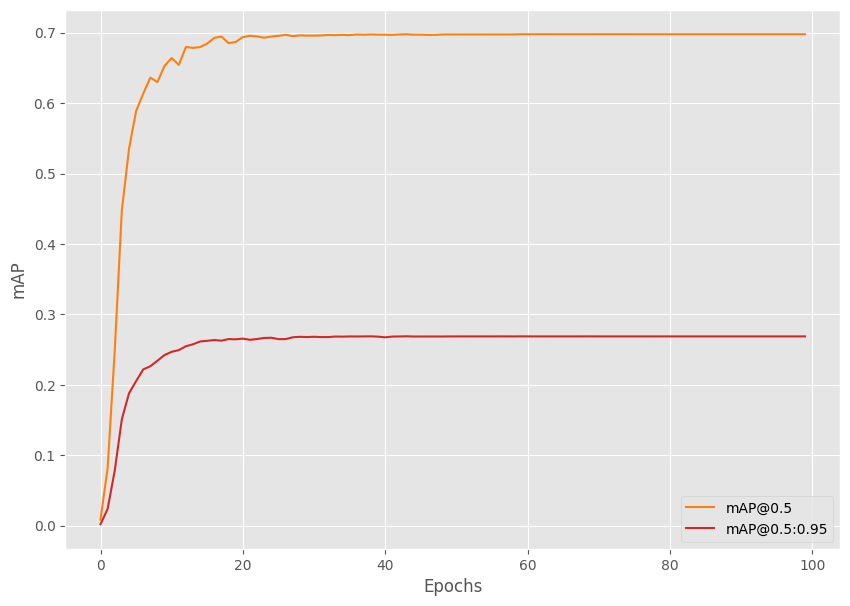

In [10]:
os.makedirs('outputs', exist_ok=True)
train_dataset = create_train_dataset(TRAIN_DIR)
valid_dataset = create_valid_dataset(VALID_DIR)
train_loader = create_train_loader(train_dataset, NUM_WORKERS)
valid_loader = create_valid_loader(valid_dataset, NUM_WORKERS)
print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of validation samples: {len(valid_dataset)}\n")

# Initialize the model and move to the computation device.
model = create_model(num_classes=NUM_CLASSES, size=RESIZE_TO, weights_path=WEIGHTS_PATH)
model = model.to(DEVICE)
# print(model)

# Total parameters and trainable parameters.
total_params = sum(p.numel() for p in model.parameters())
print(f"{total_params:,} total parameters.")
total_trainable_params = sum(
    p.numel() for p in model.parameters() if p.requires_grad)
print(f"{total_trainable_params:,} training parameters.")
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.0001, momentum=0.9, nesterov=True)
scheduler = StepLR(
    optimizer=optimizer, step_size=15, gamma=0.1, verbose=True
)

# Initialize a CSV file to store the metrics
csv_file = os.path.join(OUT_DIR, 'training_metrics.csv')
with open(csv_file, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['Epoch', 'Train Loss', 'Validation mAP50', 'Validation mAP50-95', 'Learning Rate'])

# To monitor training loss
train_loss_hist = Averager()
# To store training loss and mAP values.
train_loss_list = []
map_50_list = []
map_list = []

# Ensure the model is in training mode
model.train()

save_best_model = SaveBestModel()

# Continue with the training loop
for epoch in range(NUM_EPOCHS):
    print(f"\nEPOCH {epoch+1} of {NUM_EPOCHS}")

    # Reset the training loss histories for the current epoch.
    train_loss_hist.reset()

    # Start timer and carry out training and validation.
    start = time.time()
    train_loss = train(train_loader, model)
    metric_summary = validate(valid_loader, model)
    
    # Display training loss and validation mAP
    print(f"Epoch #{epoch+1} train loss: {train_loss_hist.value:.3f}")   
    print(f"Epoch #{epoch+1} mAP@0.5: {metric_summary['map_50']*100:.2f}%")   
    print(f"Epoch #{epoch+1} mAP@0.5:0.95: {metric_summary['map']*100:.2f}%")
    end = time.time()
    print(f"Took {((end - start) / 60):.3f} minutes for epoch {epoch}")

    # Save the loss and mAP values
    train_loss_list.append(train_loss)
    map_50_list.append(metric_summary['map_50'])
    map_list.append(metric_summary['map'])

    # Save metrics to CSV
    current_lr = scheduler.get_last_lr()[0]  # Get the current learning rate
    with open(csv_file, mode='a', newline='') as file:
        writer = csv.writer(file)
        writer.writerow([epoch+1, train_loss_hist.value, metric_summary['map_50']*100, metric_summary['map']*100, current_lr])

    # Save the best model till now.
    save_best_model(model, float(metric_summary['map']), epoch, 'outputs')

    # Save the current epoch model.
    save_model(epoch, model, optimizer)

    # Save loss plot.
    save_loss_plot(OUT_DIR, train_loss_list)

    # Save mAP plot.
    save_mAP(OUT_DIR, map_50_list, map_list)

    # Step the scheduler
    scheduler.step()

print(f"Training complete. Metrics saved to {csv_file}")

# Model Evaluation

In [6]:
model = create_model(num_classes=NUM_CLASSES, size=640, weights_path=WEIGHTS_PATH)
checkpoint = torch.load('outputs/best_model.pth', map_location=DEVICE)
model.load_state_dict(checkpoint['model_state_dict'])
model.to(DEVICE).eval()

test_dataset = create_valid_dataset(
    '/home/jupyter/ee_tree_counting/Data/Combined Dataset XML No Aug/test'
)
test_loader = create_valid_loader(test_dataset, num_workers=NUM_WORKERS)

metric_summary = validate(test_loader, model)
print(f"mAP_50: {metric_summary['map_50']*100:.3f}")
print(f"mAP_50_95: {metric_summary['map']*100:.3f}")

Validating


  0%|          | 0/12 [00:00<?, ?it/s]

mAP_50: 65.223
mAP_50_95: 25.701


# Exporting to CSV file format

In [21]:
import pandas as pd

# Create a dictionary with the data
data = {
    "Epoch": list(range(1, 101)),
    "Train Loss": [
        4.938, 4.075, 3.83, 3.696, 3.61, 3.531, 3.463, 3.412, 3.359, 3.322, 3.264, 3.22, 3.179, 3.136, 3.104, 3.063,
        3.073, 3.057, 3.058, 3.058, 3.049, 3.041, 3.036, 3.03, 3.04, 3.034, 3.017, 3.03, 3.026, 3.014, 3.018, 3.014,
        3.012, 3.017, 3.005, 3.008, 3.015, 3.009, 3.008, 3.003, 3.009, 2.999, 3.02, 3.014, 3.011, 3.007, 3.009, 3.006,
        3.005, 3.008, 3.013, 3.011, 3.004, 3.007, 3.013, 3.012, 3.007, 3.007, 3.003, 3.002, 3.014, 3.014, 3.012, 3.01,
        3.007, 3.009, 3.006, 3.004, 3.011, 3.001, 3.012, 3.01, 3.007, 3.015, 3.009, 3.004, 3.013, 3.007, 3.004, 3.01,
        3.012, 3.007, 3.009, 3.009, 3.007, 3.017, 3.01, 3.004, 3.013, 3.007, 3.014, 3.009, 3.006, 3.007, 3.008, 3.01,
        3.008, 3.007, 3.006, 3.008
    ],
    "mAP": [
        0.0020383174996823072, 0.022861845791339874, 0.08308479189872742, 0.14638210833072662, 0.18756431341171265,
        0.20833797752857208, 0.2192489504814148, 0.22915536165237427, 0.23228442668914795, 0.24335764348506927,
        0.24488072097301483, 0.24967779219150543, 0.25477665662765503, 0.2594020962715149, 0.2659323215484619,
        0.262830913066864, 0.26334813237190247, 0.26300138235092163, 0.2632383406162262, 0.2628127336502075,
        0.2647073566913605, 0.2639809250831604, 0.2655472755432129, 0.2646346390247345, 0.2666299641132355,
        0.2656112015247345, 0.2669174373149872, 0.26502883434295654, 0.2670244872570038, 0.26789408922195435,
        0.2672414183616638, 0.26779478788375854, 0.2676714062690735, 0.26808544993400574, 0.2677479684352875,
        0.2680380940437317, 0.26814815402030945, 0.2681480348110199, 0.2679618000984192, 0.2680222690105438,
        0.2683304250240326, 0.2683519721031189, 0.2682887315750122, 0.2683258354663849, 0.2684342861175537,
        0.2684059739112854, 0.2683124840259552, 0.2683514654636383, 0.26834672689437866, 0.2683456838130951,
        0.26834726333618164, 0.2683553993701935, 0.26837506890296936, 0.26835018396377563, 0.26836878061294556,
        0.2683883309364319, 0.268428236246109, 0.2684257924556732, 0.2681969106197357, 0.2683669328689575,
        0.2683667540550232, 0.2683667540550232, 0.2683671712875366, 0.2683606445789337, 0.26836055517196655,
        0.2683664560317993, 0.26836705207824707, 0.2683640420436859, 0.26836854219436646, 0.2683689296245575,
        0.2683689296245575, 0.2683689296245575, 0.26836901903152466, 0.2683681845664978, 0.2683696448802948,
        0.2683696448802948, 0.2683696448802948, 0.2683698832988739, 0.2683696448802948, 0.2683698832988739,
        0.2683698832988739, 0.2683698832988739, 0.2683698832988739, 0.2683698832988739, 0.2683698832988739,
        0.2683698832988739, 0.2683698832988739, 0.2683698832988739, 0.2683698832988739, 0.2683698832988739,
        0.2683698832988739, 0.2683698832988739, 0.2683698832988739, 0.2683698832988739, 0.2683698832988739,
        0.26836860179901123, 0.2683698832988739, 0.2683698832988739, 0.2683698832988739, 0.2683698832988739
    ]
}

# Convert dictionary to DataFrame
df = pd.DataFrame(data)

# Save DataFrame to CSV

df.to_csv('training_log_100eNoAug.csv', index=False)

csv_file_path


'outputs'

## Inference on Satellite Imagery

In [6]:
import os
import numpy as np
import cv2
import torch
import time
import pandas as pd

from model import create_model
from config import NUM_CLASSES, DEVICE, CLASSES

np.random.seed(42)

# Define the path to your satellite image
satellite_image_path = '/home/jupyter/ee_tree_counting/Sample Images/GEE Sample Images/Region_7_Spain_png.rf.45c8864edc44300a9e07e25bd60f7206.jpg' 
image_size = None  # Set this to the desired image size, e.g., 640, or leave it as None to use original size
detection_threshold = 0.35  # Set the detection threshold

output_dir = 'visualisations/SSD_Satellite_Inference'
os.makedirs(output_dir, exist_ok=True)

# Set the color for bounding boxes to blue.
BLUE_COLOR = (255, 0, 0)  # BGR format, blue color

# Load the best model and trained weights.
model = create_model(num_classes=NUM_CLASSES)
checkpoint = torch.load('/home/jupyter/ee_tree_counting/Models/SSD/outputs/SSD Tree Result/best_model.pth', map_location=DEVICE)
model.load_state_dict(checkpoint['model_state_dict'])
model.to(DEVICE).eval()

# Load and preprocess the satellite image
image_name = os.path.splitext(os.path.basename(satellite_image_path))[0]
image = cv2.imread(satellite_image_path)
orig_image = image.copy()

if image_size is not None:
    image = cv2.resize(image, (image_size, image_size))

image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
image /= 255.0
image_input = np.transpose(image, (2, 0, 1)).astype(np.float32)
image_input = torch.tensor(image_input, dtype=torch.float).unsqueeze(0).to(DEVICE)

# Perform inference
start_time = time.time()
with torch.no_grad():
    outputs = model(image_input)
end_time = time.time()

outputs = [{k: v.to('cpu') for k, v in t.items()} for t in outputs]

# Filter results by detection threshold
detected_boxes = len(outputs[0]['boxes'])

if detected_boxes > 0:
    boxes = outputs[0]['boxes'].data.numpy()
    scores = outputs[0]['scores'].data.numpy()
    boxes = boxes[scores >= detection_threshold].astype(np.int32)
    scores = scores[scores >= detection_threshold]

    for box, score in zip(boxes, scores):
        xmin, ymin, xmax, ymax = box
        cv2.rectangle(orig_image, (xmin, ymin), (xmax, ymax), BLUE_COLOR, 3)
        cv2.putText(orig_image, f"tree: {score:.2f}", (xmin, ymin - 5), 
                    cv2.FONT_HERSHEY_SIMPLEX, 0.8, BLUE_COLOR, 2, lineType=cv2.LINE_AA)

    # Save the output image with bounding boxes and scores
    output_image_path = os.path.join(output_dir, f"{image_name}_inference.jpg")
    cv2.imwrite(output_image_path, orig_image)
    print(f"Inference complete. Output saved at {output_image_path}")
else:
    print("No objects detected.")

# Print inference time
print(f"Inference Time: {end_time - start_time:.2f} seconds")


Inference complete. Output saved at visualisations/SSD_Satellite_Inference/Region_7_Spain_png.rf.45c8864edc44300a9e07e25bd60f7206_inference.jpg
Inference Time: 0.03 seconds
